In [1]:
import json
import pandas as pd
from pathlib import Path
from typing import Dict, Any

# 指定目录和 json 文件
data_dir = Path('.')
json_files = [
    'refactored_alpha_gfn_bitseq.json',
    'rebuttal_bit_fl.json',
    'refactored_alpha_gfn_bitseq_icml2026.json'
]

def flatten_dict(d: Dict[str, Any], parent_key: str = '', sep: str = '_') -> Dict[str, Any]:
    """递归展平嵌套字典"""
    items = []
    for k, v in d.items():
        new_key = f"{parent_key}{sep}{k}" if parent_key else k
        if isinstance(v, dict):
            items.extend(flatten_dict(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

# 加载所有 json 文件并解析为 DataFrame
all_data = []

for file in json_files:
    file_path = data_dir / file
    with open(file_path, 'r') as f:
        data = json.load(f)

    # 每个 json 文件的顶层 key 是实验名称，value 是参数字典
    for exp_name, exp_params in data.items():
        flat_params = flatten_dict(exp_params)
        flat_params['experiment_name'] = exp_name  # 保存实验名称
        flat_params['source_file'] = file  # 保存来源文件
        all_data.append(flat_params)

# 转换为 DataFrame
df = pd.DataFrame(all_data)

print(f"✓ 加载完成！共 {len(df)} 行")
print(f"✓ 列数: {len(df.columns)}")
print(f"\n数据源: {json_files}")
print(f"\nDataFrame 形状: {df.shape}")
print(f"\n前几行:")
df.head()

✓ 加载完成！共 1125 行
✓ 列数: 90

数据源: ['refactored_alpha_gfn_bitseq.json', 'rebuttal_bit_fl.json', 'refactored_alpha_gfn_bitseq_icml2026.json']

DataFrame 形状: (1125, 90)

前几行:


,M_size,_runtime,_step,_test_tokens__type,_timestamp,alpha,alpha_init,alpha_sched,alpha_warm_frac,avg_current_reward_eval,...,qgfn_tau,qgfn_variant,spearman_corr_test_unscaled,top_1000_count,top_100_count,top_k,avg_current_reward_eval_scaled,checkpoint_dir,checkpoint_every,resume_checkpoint
0,60.0,50082.229668,49999,histogram,1.758340e+09,0.503665,0.7,hold_exp,0.8,6.366812e-39,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,60.0,90905.526636,49999,histogram,1.758381e+09,0.505497,0.8,hold_exp,0.8,1.149229e-36,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,60.0,78799.941123,49999,histogram,1.758369e+09,0.494503,0.2,hold_exp,0.8,1.130852e-36,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,60.0,31784.249645,49999,histogram,1.758290e+09,0.500000,0.5,hold_exp,0.8,4.573409e-34,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,60.0,82301.522906,49999,histogram,1.758379e+09,0.498168,0.4,hold_exp,0.8,2.152297e-38,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
import re
import numpy as np

# 复制一份以免污染原始 df
df_all = df.copy()

# 解析实验名称中的参数
def parse_exp_name(exp_name: str) -> dict:
    params = {}
    ss_match = re.search(r'ss\((\d+)\)', exp_name)
    if ss_match:
        params['seed'] = int(ss_match.group(1))

    m_match = re.search(r'_m\(([^)]+)\)', exp_name)
    if m_match:
        params['method'] = m_match.group(1)

    k_match = re.search(r'k\(([^)]+)\)', exp_name)
    if k_match:
        params['k'] = k_match.group(1)

    a_match = re.search(r'_a\(([^)]+)\)', exp_name)
    if a_match:
        try:
            params['alpha_init_from_name'] = float(a_match.group(1))
        except ValueError:
            params['alpha_init_from_name'] = np.nan

    return params

parsed_rows = []
for _, row in df_all.iterrows():
    name = row.get('experiment_name', '')
    parsed = parse_exp_name(name)
    method = parsed.get('method')
    
    # 来自这两个文件的method加上"fl-"前缀
    source_file = row.get('source_file', '')
    if source_file in ['refactored_alpha_gfn_bitseq_icml2026.json', 'rebuttal_bit_fl.json']:
        if method:
            method = f"fl-{method}"
    
    parsed_rows.append({
        **row,
        'seed': parsed.get('seed'),
        'method': method,
        'k': parsed.get('k'),
        'alpha_init_name': parsed.get('alpha_init_from_name'),
        'alpha': row.get('alpha_init', row.get('alpha'))
    })

df_all = pd.DataFrame(parsed_rows)

print(f"总实验数: {len(df_all)}")
print(f"Unique seeds: {sorted(df_all['seed'].dropna().unique())}")
print(f"Unique k: {sorted(df_all['k'].dropna().unique())}")
print(f"Unique alphas (from alpha_init): {sorted(df_all['alpha'].dropna().unique())}")
print(f"Unique objectives/methods: {sorted(df_all['method'].dropna().unique())}")
print("\n数据来源分布:")
print(df_all.groupby(['source_file', 'method', 'k']).size())

# 只保留需要的指标
metrics = ['modes', 'spearman_corr_test', 'mean_top_1000_R']
available_metrics = [m for m in metrics if m in df_all.columns]
missing_metrics = [m for m in metrics if m not in df_all.columns]

if missing_metrics:
    print(f"⚠️ 缺失指标: {missing_metrics}")
    print(f"✓ 可用指标: {available_metrics}\n")
    metrics = available_metrics

objectives = sorted(df_all['method'].dropna().unique())
ks = sorted(df_all['k'].dropna().unique())

print(f"\n{'=' * 80}")
print(f"找到 {len(objectives)} 个 objectives: {objectives}")
print(f"找到 {len(ks)} 个 k: {ks}")
print(f"{'=' * 80}")

# 收集绘图配置
fig_configs = []

for obj in objectives:
    for k in ks:
        print(f"\n{'=' * 80}")
        print(f"Objective: {obj}, k: {k}")
        print(f"{'=' * 80}")

        df_obj = df_all[(df_all['method'] == obj) & (df_all['k'] == k)].copy()
        if len(df_obj) == 0:
            print("无数据，跳过")
            continue

        print(f"  实验数: {len(df_obj)}")
        print(f"  来源文件: {df_obj['source_file'].unique()}")

        df_averaged = df_obj.groupby('alpha')[metrics].mean().reset_index()
        df_averaged = df_averaged.sort_values('alpha')

        print("\n按 seed 平均后的结果 (基于 alpha_init):")
        print(df_averaged.to_string(index=False))

        print("\n最优 Alpha 分析:")
        print(f"{'-' * 80}")
        for metric in metrics:
            if len(df_averaged) > 0 and not df_averaged[metric].isna().all():
                best_idx = df_averaged[metric].idxmax()
                best_alpha = df_averaged.loc[best_idx, 'alpha']
                best_value = df_averaged.loc[best_idx, metric]
                print(f"  {metric:30s} -> 最优 alpha_init: {best_alpha:.4f}, 最优值: {best_value:.6f}")

        plot_metrics = [m for m in metrics if not df_averaged[m].isna().all()]
        if plot_metrics:
            fig_configs.append({
                'method': obj,
                'k': k,
                'data': df_averaged,
                'metrics': plot_metrics
            })

总实验数: 1125
Unique seeds: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)]
Unique k: ['10', '2', '4', '6', '8']
Unique alphas (from alpha_init): [np.float64(0.1), np.float64(0.2), np.float64(0.3), np.float64(0.4), np.float64(0.5), np.float64(0.6), np.float64(0.7), np.float64(0.8), np.float64(0.9)]
Unique objectives/methods: ['db', 'fl-db', 'fl-subtb', 'subtb', 'tb']

数据来源分布:
source_file                                method    k 
rebuttal_bit_fl.json                       fl-db     10    45
                                                     4     45
                                                     6     45
                                                     8     45
                                           fl-subtb  10    45
                                                     4     45
                                                     6     45
                                                     8     45
refactored_alpha_gfn_bitseq.json           db        1


生成图表


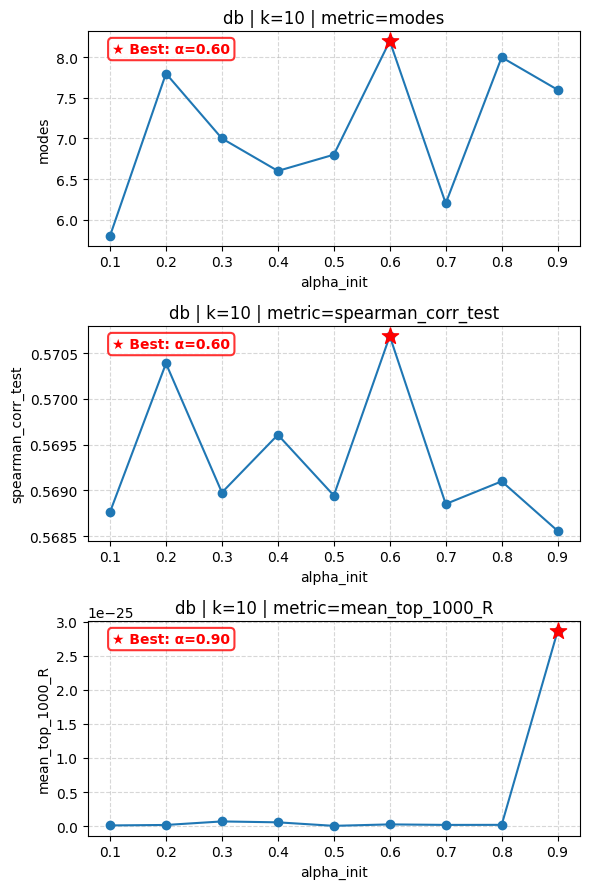

保存: side_product\bit_analysis_db_10.png


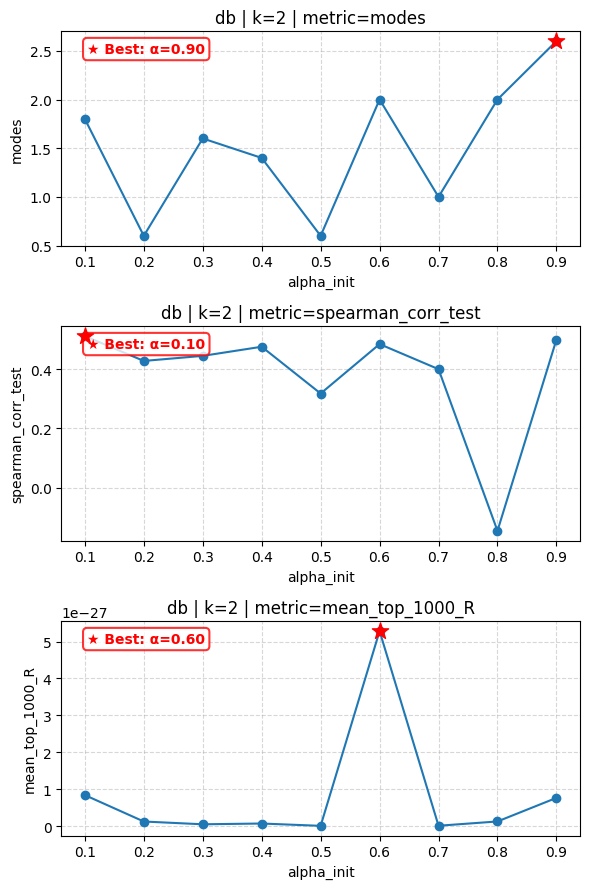

保存: side_product\bit_analysis_db_2.png


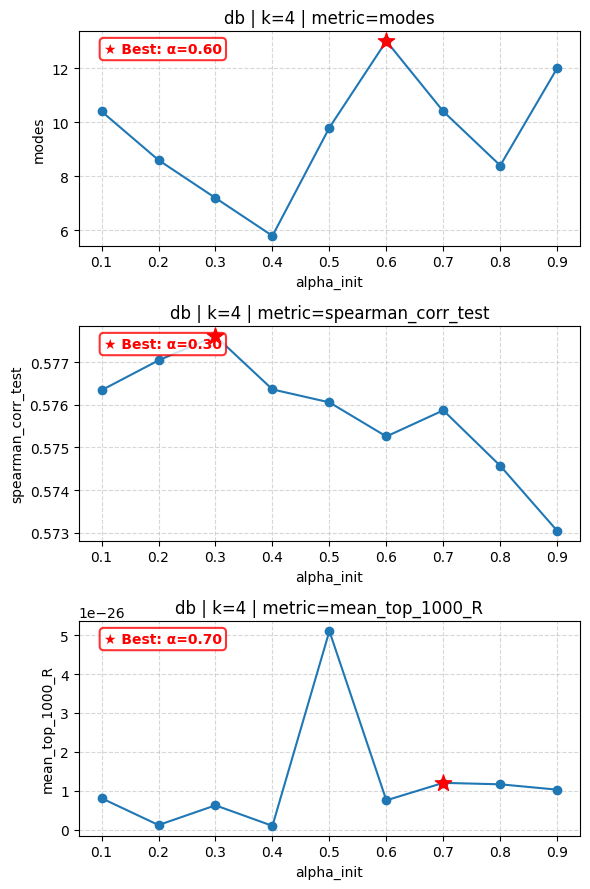

保存: side_product\bit_analysis_db_4.png


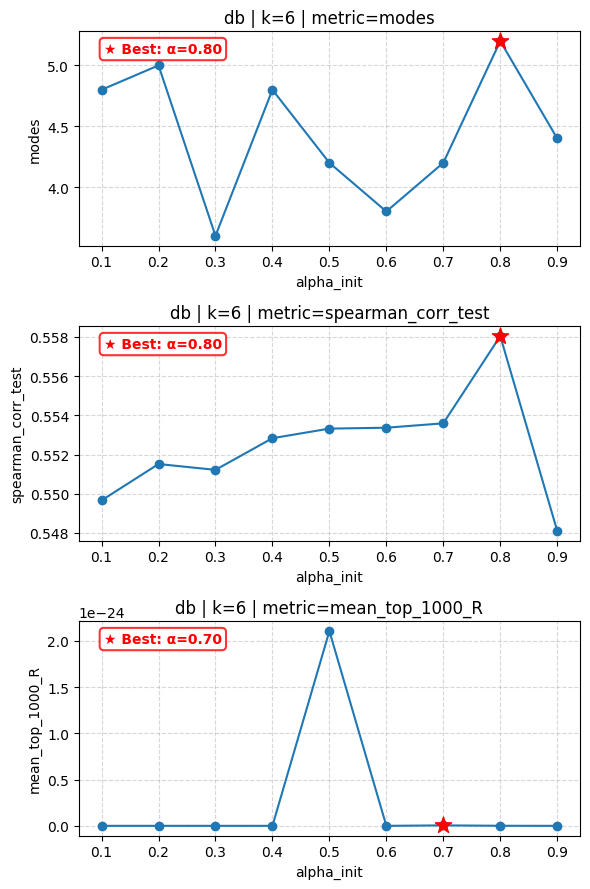

保存: side_product\bit_analysis_db_6.png


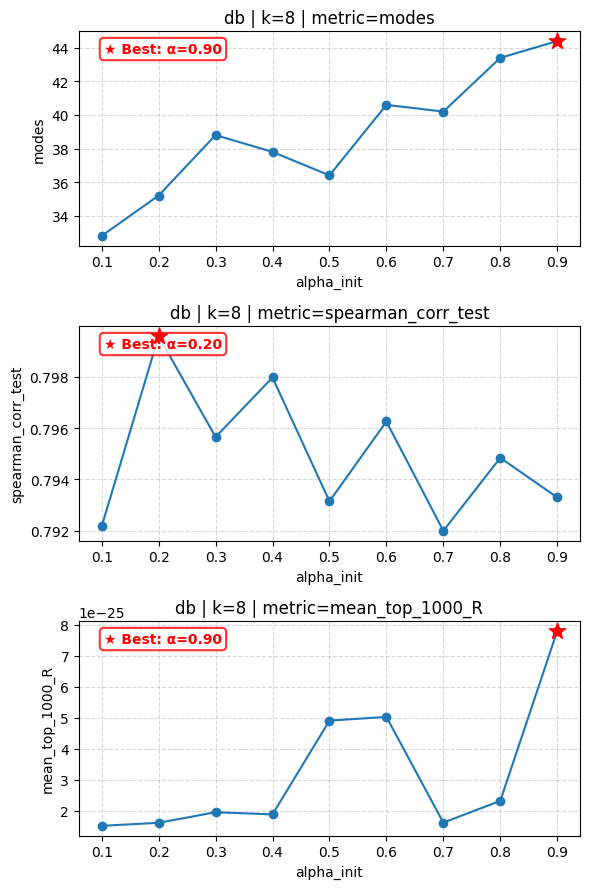

保存: side_product\bit_analysis_db_8.png


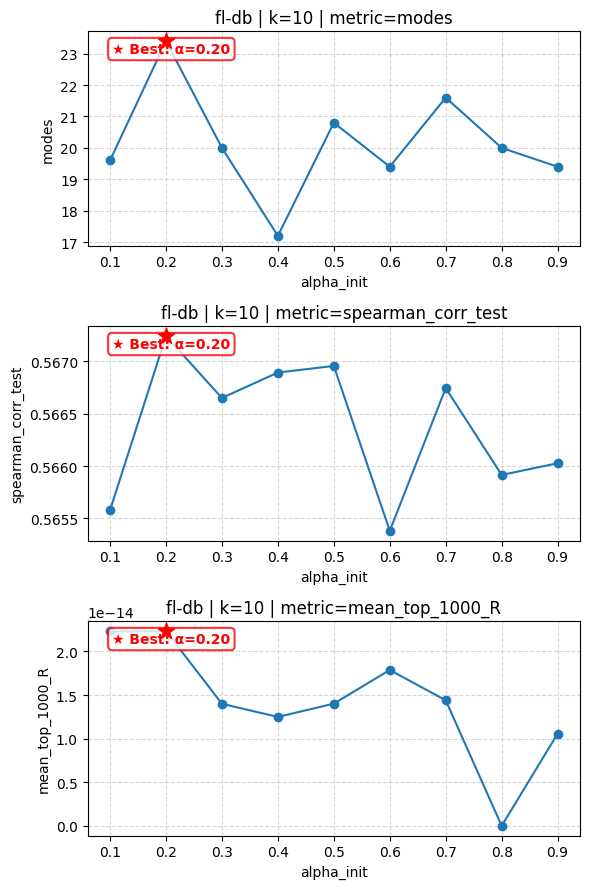

保存: side_product\bit_analysis_fl-db_10.png


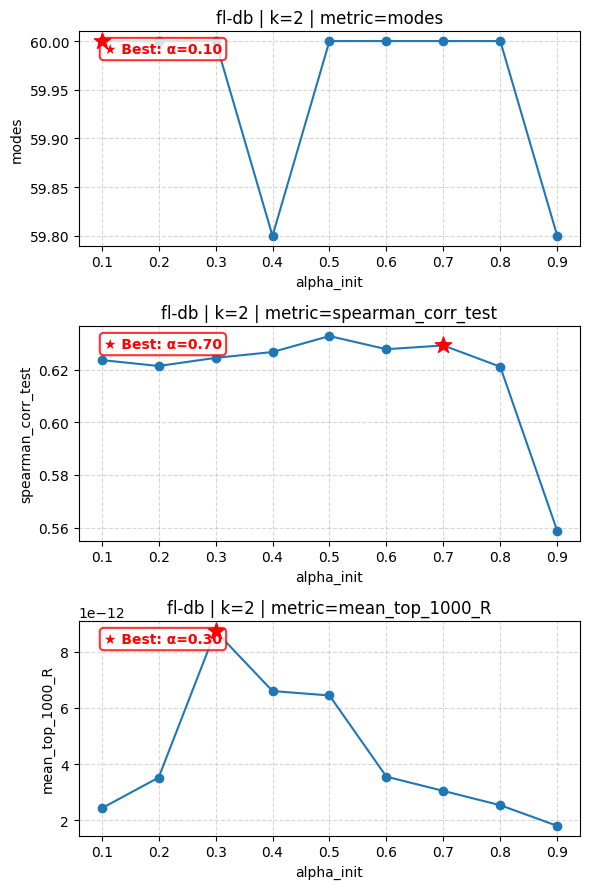

保存: side_product\bit_analysis_fl-db_2.png


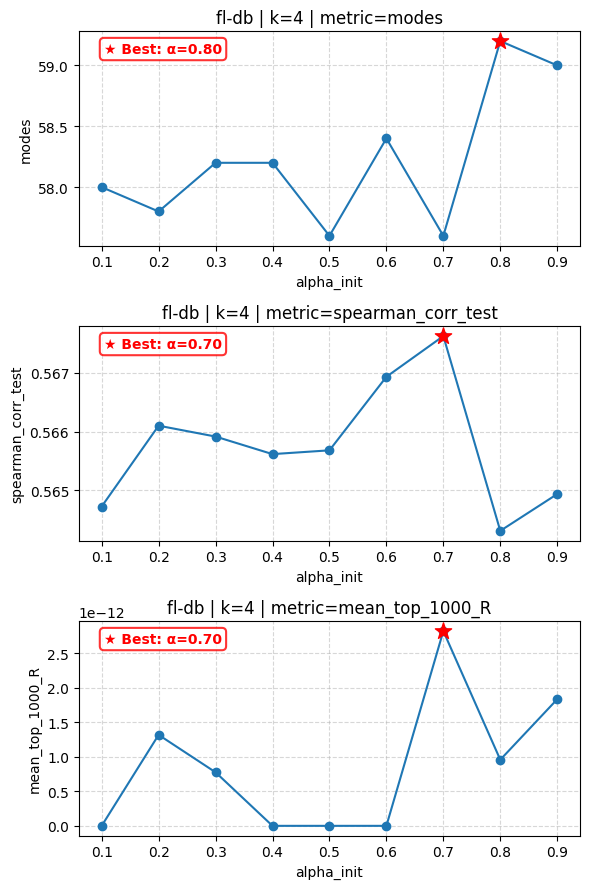

保存: side_product\bit_analysis_fl-db_4.png


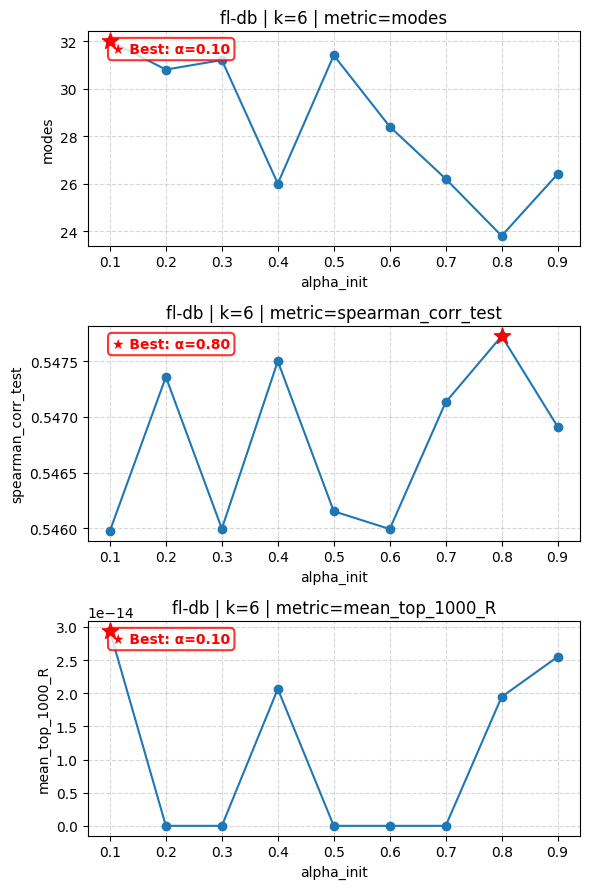

保存: side_product\bit_analysis_fl-db_6.png


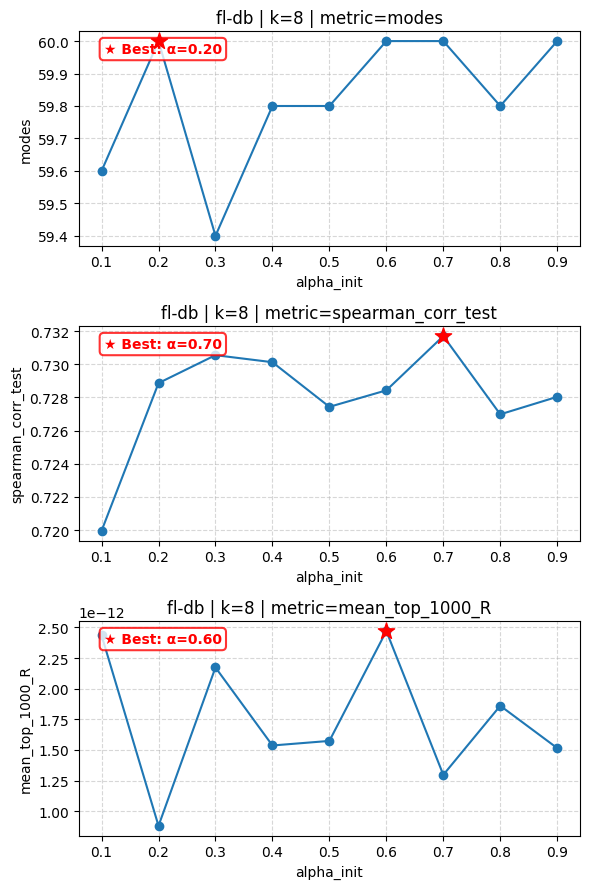

保存: side_product\bit_analysis_fl-db_8.png


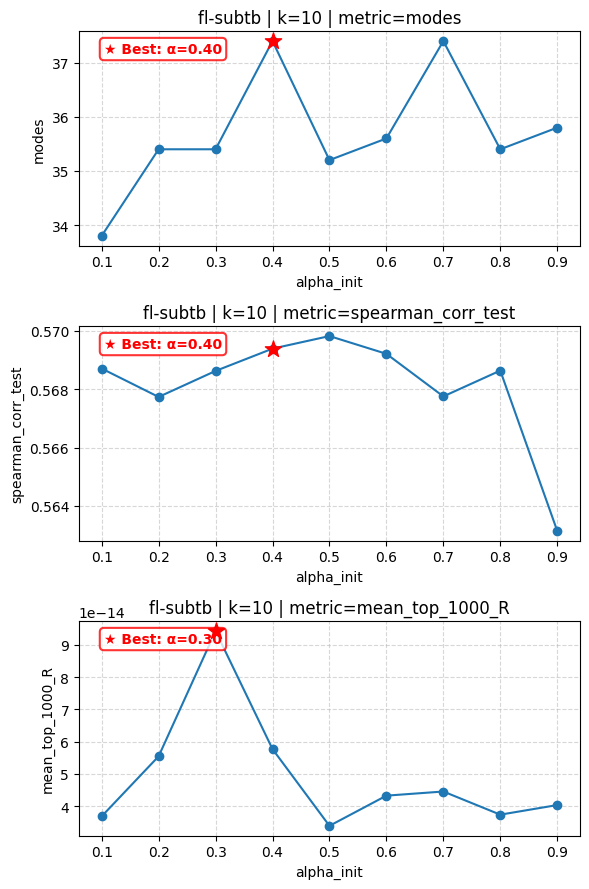

保存: side_product\bit_analysis_fl-subtb_10.png


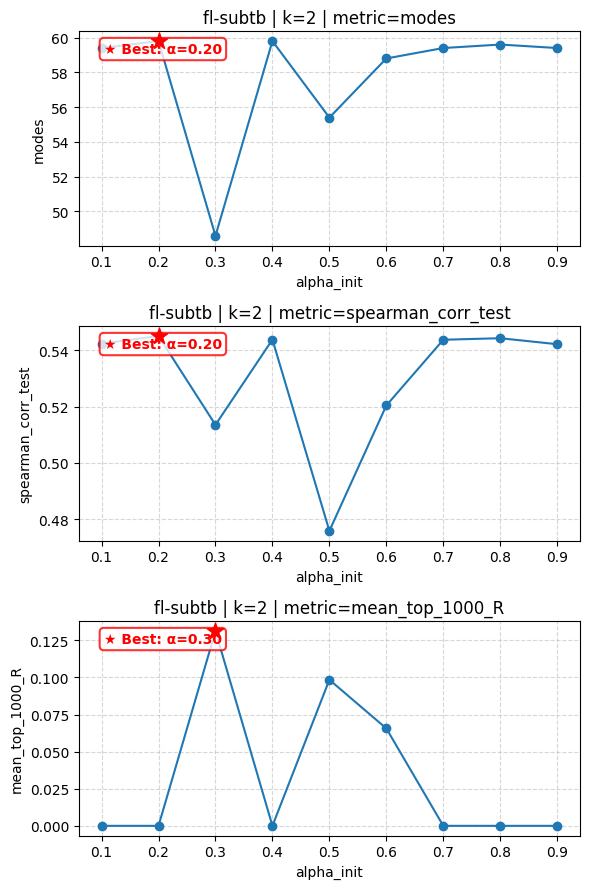

保存: side_product\bit_analysis_fl-subtb_2.png


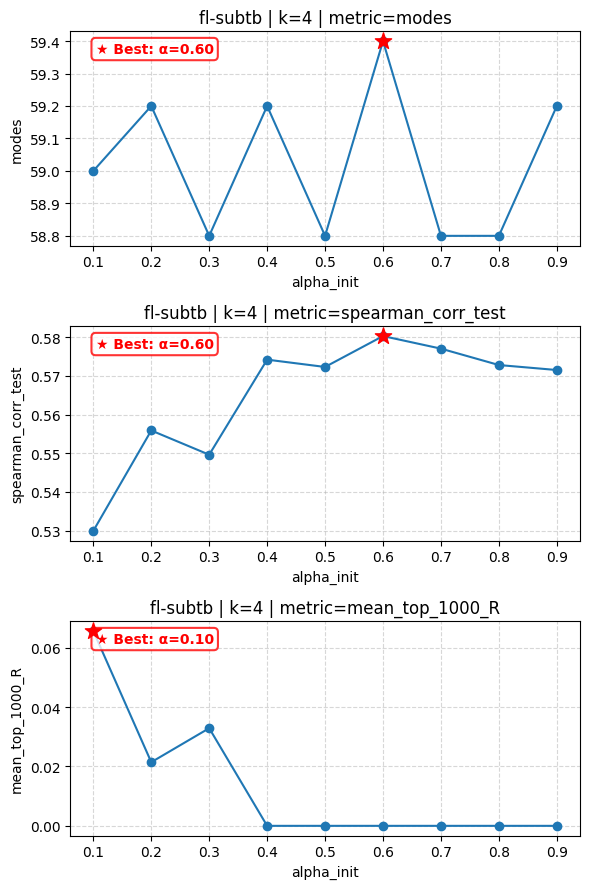

保存: side_product\bit_analysis_fl-subtb_4.png


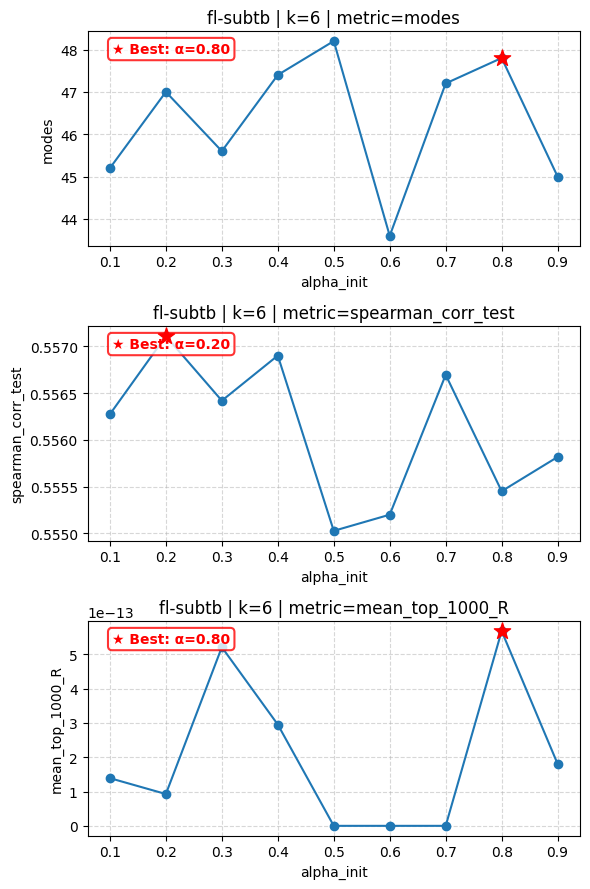

保存: side_product\bit_analysis_fl-subtb_6.png


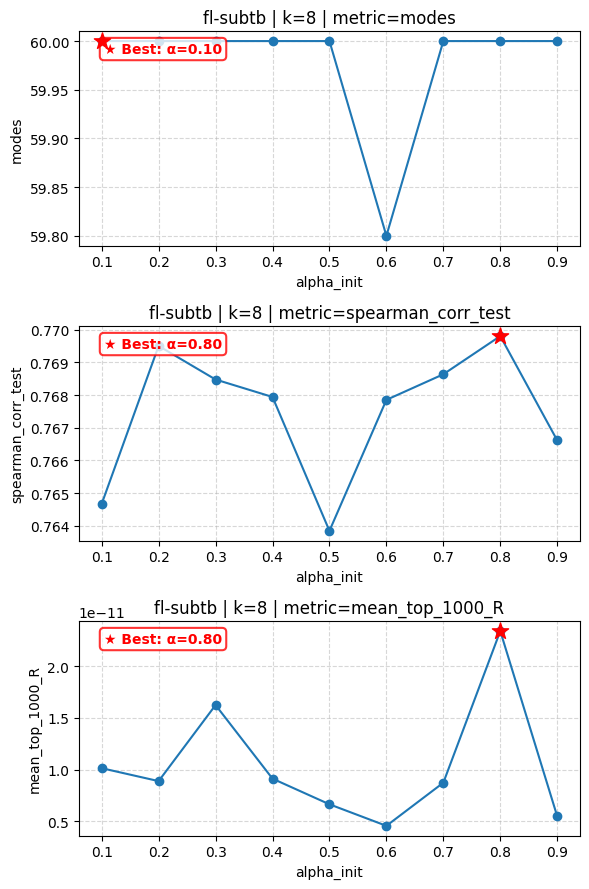

保存: side_product\bit_analysis_fl-subtb_8.png


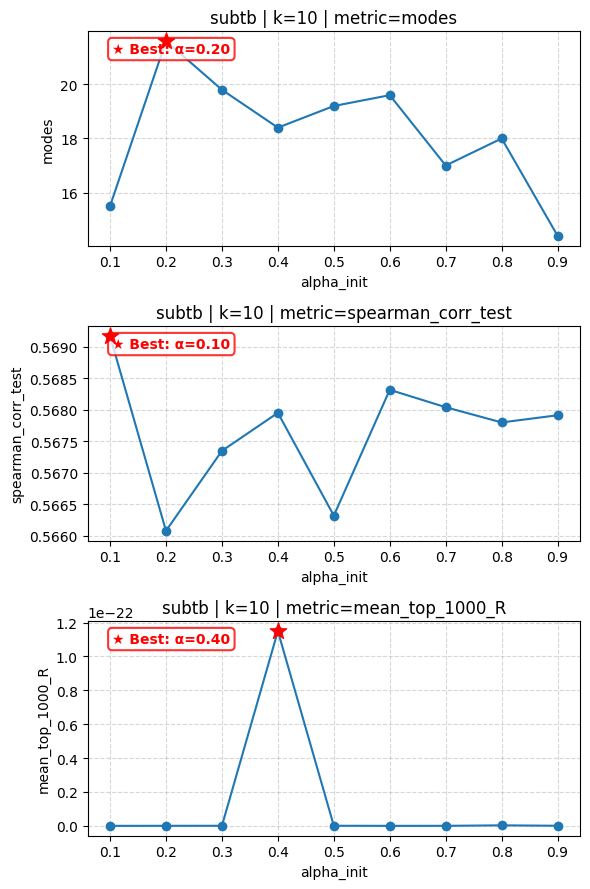

保存: side_product\bit_analysis_subtb_10.png


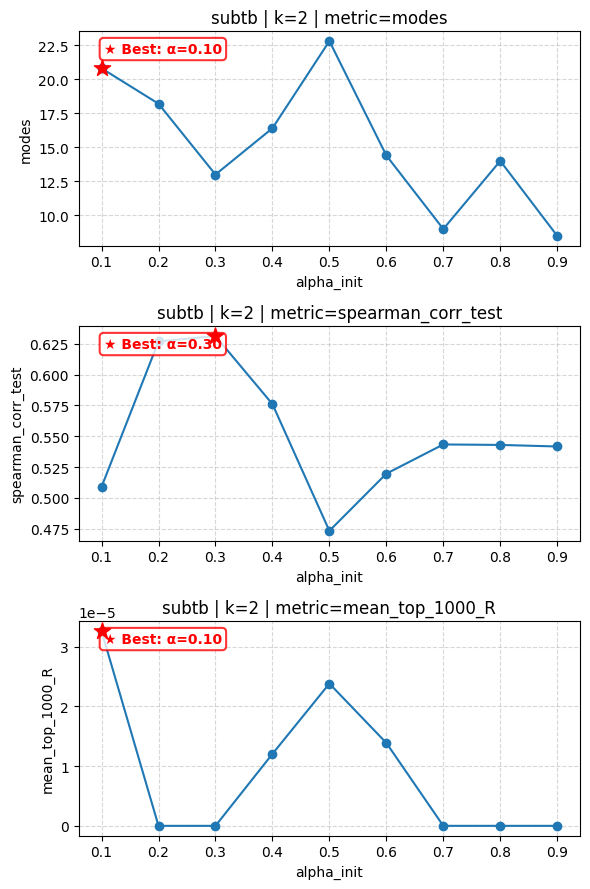

保存: side_product\bit_analysis_subtb_2.png


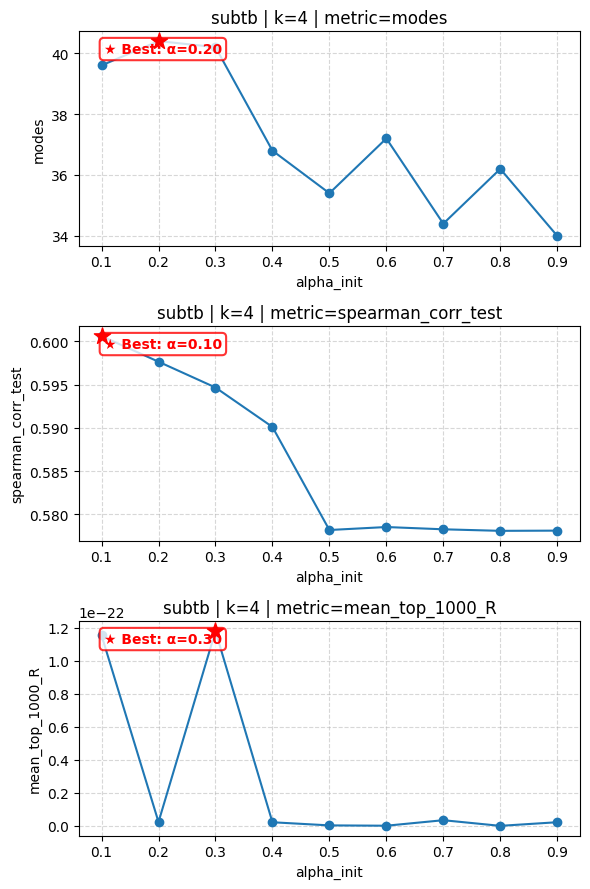

保存: side_product\bit_analysis_subtb_4.png


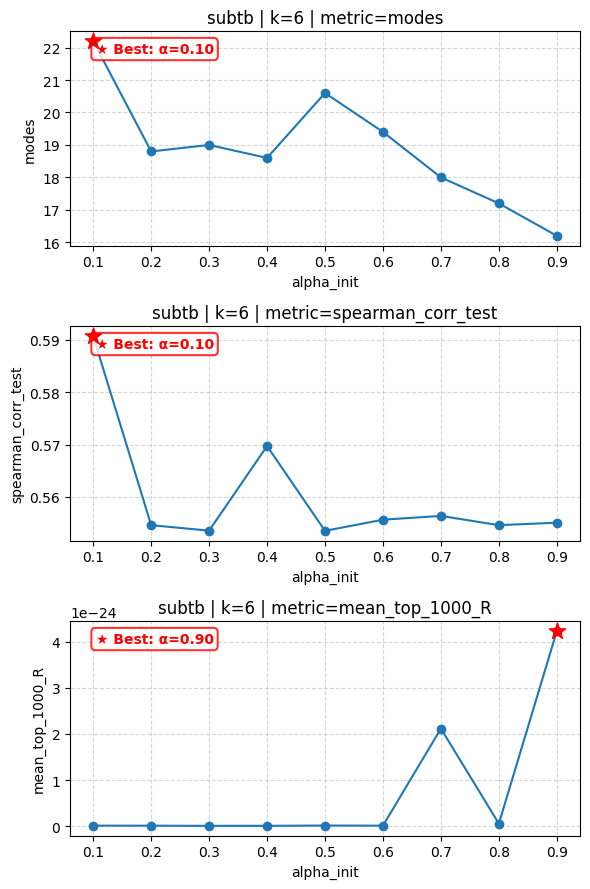

保存: side_product\bit_analysis_subtb_6.png


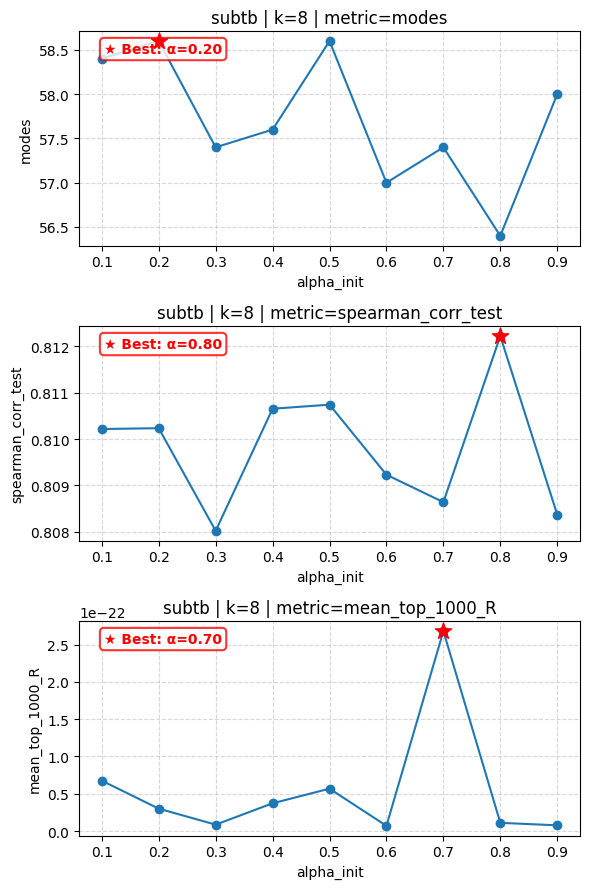

保存: side_product\bit_analysis_subtb_8.png


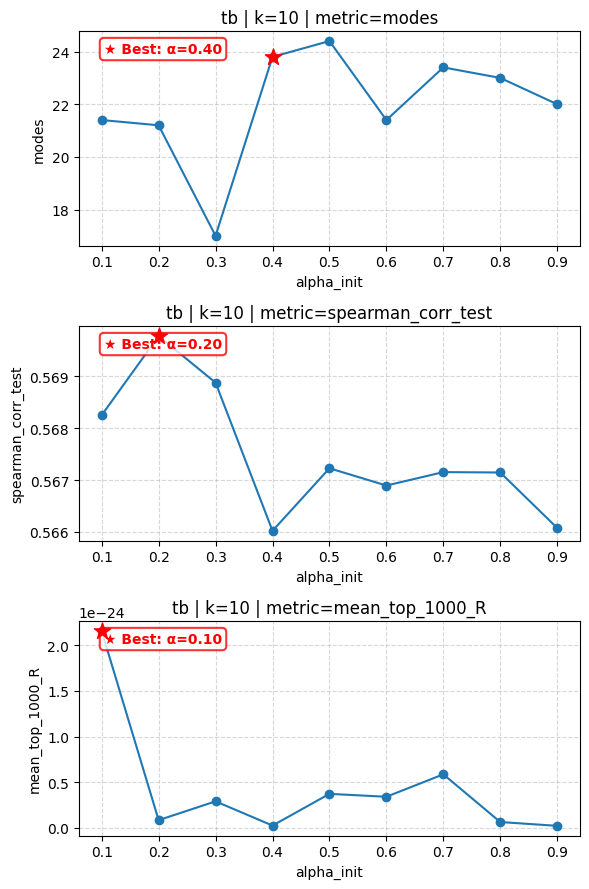

保存: side_product\bit_analysis_tb_10.png


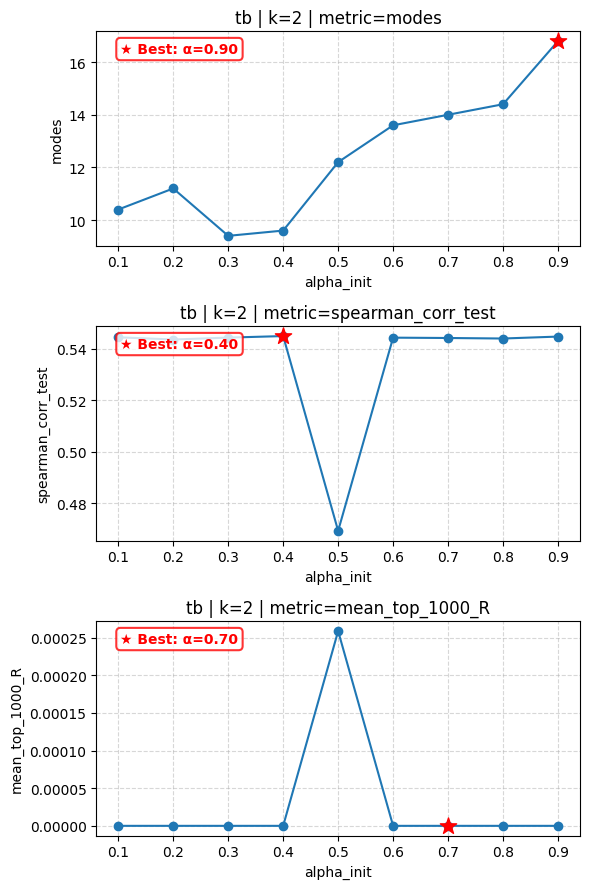

保存: side_product\bit_analysis_tb_2.png


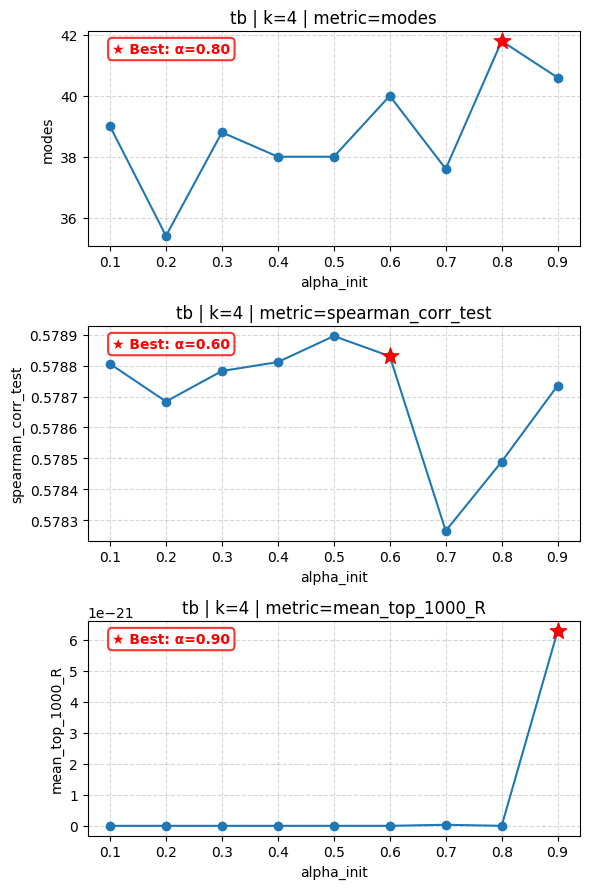

保存: side_product\bit_analysis_tb_4.png


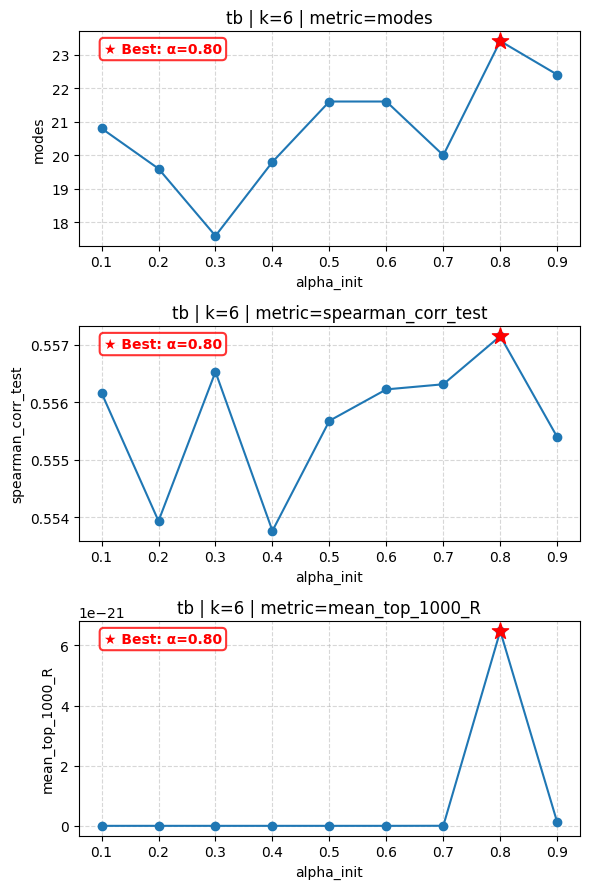

保存: side_product\bit_analysis_tb_6.png


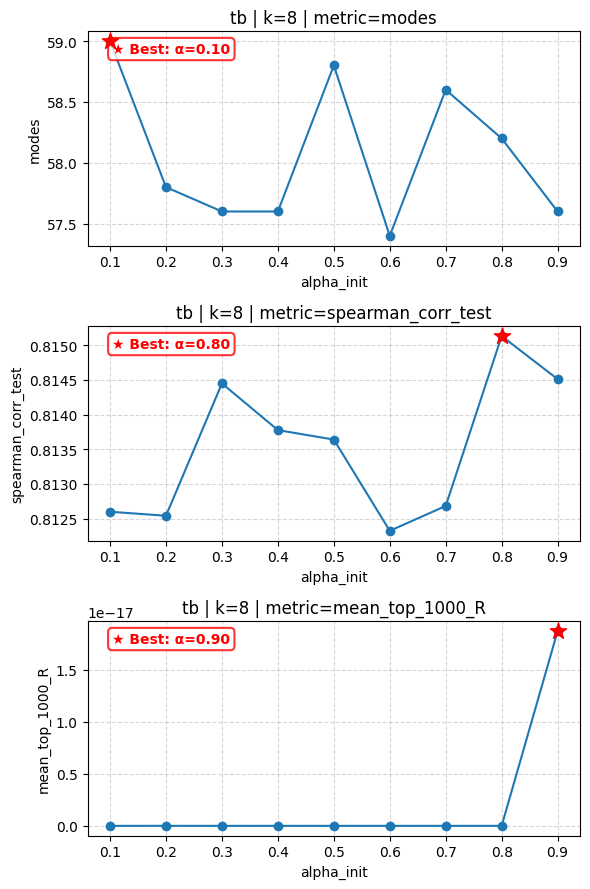

保存: side_product\bit_analysis_tb_8.png

全部图表生成完毕。


In [3]:
import matplotlib.pyplot as plt

out_dir = Path('side_product')
out_dir.mkdir(exist_ok=True, parents=True)

print(f"\n{'=' * 80}\n生成图表\n{'=' * 80}")
for cfg in fig_configs:
    obj = cfg['method']
    k = cfg['k']
    data = cfg['data']
    metrics_to_plot = cfg['metrics']

    fig, axes = plt.subplots(len(metrics_to_plot), 1, figsize=(6, 3 * len(metrics_to_plot)))
    if len(metrics_to_plot) == 1:
        axes = [axes]

    for ax, metric in zip(axes, metrics_to_plot):
        ax.plot(data['alpha'], data[metric], marker='o')
        
        # 找到最优 alpha 并标注
        if len(data) > 0 and not data[metric].isna().all():
            # 排除 alpha=0.5，选择第二好的；否则选最优的
            sorted_data = data.sort_values(metric, ascending=False)
            candidates = sorted_data[sorted_data['alpha'] != 0.5]
            if len(candidates) > 0:
                best_idx = candidates.index[0]
            else:
                best_idx = data[metric].idxmax()
            
            best_alpha = data.loc[best_idx, 'alpha']
            best_value = data.loc[best_idx, metric]
            
            # 标注最优点（红星）
            ax.scatter([best_alpha], [best_value], color='red', s=150, zorder=5, marker='*')
            
            # 在左上角添加 legend 显示最优 alpha
            ax.text(0.05, 0.95, f'★ Best: α={best_alpha:.2f}', 
                   transform=ax.transAxes,
                   fontsize=10,
                   fontweight='bold',
                   color='red',
                   verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='red', linewidth=1.5))
        
        ax.set_title(f"{obj} | k={k} | metric={metric}")
        ax.set_xlabel('alpha_init')
        ax.set_ylabel(metric)
        ax.grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout()
    save_path = out_dir / f"bit_analysis_{obj}_{k}.png"
    plt.savefig(save_path, dpi=200)
    plt.show()
    print(f"保存: {save_path}")

print("\n全部图表生成完毕。")

In [4]:
# 记录每个 cfg 对应的最优 alpha（用于筛选）
best_alpha_records = []

for cfg in fig_configs:
    obj = cfg['method']
    k = cfg['k']
    data = cfg['data']
    metrics_to_plot = cfg['metrics']
    
    for metric in metrics_to_plot:
        if len(data) > 0 and not data[metric].isna().all():
            # 使用相同的逻辑查找 best_alpha
            sorted_data = data.sort_values(metric, ascending=False)
            candidates = sorted_data[sorted_data['alpha'] != 0.5]
            if len(candidates) > 0:
                best_idx = candidates.index[0]
            else:
                best_idx = data[metric].idxmax()
            
            best_alpha = data.loc[best_idx, 'alpha']
            best_value = data.loc[best_idx, metric]
            
            best_alpha_records.append({
                'method': obj,
                'k': k,
                'metric': metric,
                'best_alpha': best_alpha,
                'best_value': best_value
            })

# 转换为 DataFrame 并显示
df_best_alphas = pd.DataFrame(best_alpha_records)
print("\n" + "=" * 80)
print("最优 Alpha 汇总")
print("=" * 80)
print(df_best_alphas.to_string(index=False))

# 保存汇总表
best_alpha_csv_path = out_dir / 'best_alphas_summary.csv'
df_best_alphas.to_csv(best_alpha_csv_path, index=False)
print(f"\n✓ 已保存到: {best_alpha_csv_path}")

# 按照 best_alpha 筛选原始数据（保留所有 metric）
print("\n" + "=" * 80)
print("按照 best_alpha 筛选原始数据（保留所有指标）")
print("=" * 80)

best_alpha_data_records = []
# 获取每个 (method, k) 的唯一 best_alpha
for method in df_best_alphas['method'].unique():
    for k in df_best_alphas[df_best_alphas['method'] == method]['k'].unique():
        # 取该 (method, k) 的第一个 best_alpha（假设同一 method-k 的所有 metric 的 best_alpha 相同或取最常见的）
        best_alphas_for_mk = df_best_alphas[(df_best_alphas['method'] == method) & (df_best_alphas['k'] == k)]['best_alpha']
        if len(best_alphas_for_mk) > 0:
            best_alpha = best_alphas_for_mk.iloc[0]  # 取第一个
            
            # 从原始数据中筛选出该 method、k、alpha 的所有记录
            mask = (df_all['method'] == method) & (df_all['k'] == k) & (df_all['alpha'] == best_alpha)
            matched_rows = df_all[mask]
            
            if len(matched_rows) > 0:
                # 计算平均和标准差
                record = {
                    'method': method,
                    'k': k,
                    'alpha': best_alpha,
                }
                for m in metrics:
                    record[f'{m}_mean'] = matched_rows[m].mean()
                    record[f'{m}_std'] = matched_rows[m].std()
                best_alpha_data_records.append(record)

df_best_alpha_data = pd.DataFrame(best_alpha_data_records)
print(df_best_alpha_data.to_string(index=False))

best_alpha_data_path = out_dir / 'best_alpha_data.csv'
df_best_alpha_data.to_csv(best_alpha_data_path, index=False)
print(f"\n✓ 已保存到: {best_alpha_data_path}")

# 保存 alpha_init=0.5 的 baseline 数据（包含均值和标准差）
print("\n" + "=" * 80)
print("Baseline 数据 (alpha_init=0.5) 的均值和标准差")
print("=" * 80)

baseline_records = []
for obj in objectives:
    for k in ks:
        df_obj = df_all[(df_all['method'] == obj) & (df_all['k'] == k) & (df_all['alpha'] == 0.5)].copy()
        if len(df_obj) > 0:
            record = {
                'method': obj,
                'k': k,
                'alpha': 0.5,
            }
            for m in metrics:
                record[f'{m}_mean'] = df_obj[m].mean()
                record[f'{m}_std'] = df_obj[m].std()
            baseline_records.append(record)

df_baseline = pd.DataFrame(baseline_records)
if len(df_baseline) > 0:
    print(df_baseline.to_string(index=False))
    baseline_path = out_dir / 'baseline_alpha0.5_data.csv'
    df_baseline.to_csv(baseline_path, index=False)
    print(f"\n✓ 已保存到: {baseline_path}")
else:
    print("没有找到 alpha=0.5 的数据")


最优 Alpha 汇总
  method  k             metric  best_alpha   best_value
      db 10              modes         0.6 8.200000e+00
      db 10 spearman_corr_test         0.6 5.706857e-01
      db 10    mean_top_1000_R         0.9 2.861561e-25
      db  2              modes         0.9 2.600000e+00
      db  2 spearman_corr_test         0.1 5.123852e-01
      db  2    mean_top_1000_R         0.6 5.284087e-27
      db  4              modes         0.6 1.300000e+01
      db  4 spearman_corr_test         0.3 5.776133e-01
      db  4    mean_top_1000_R         0.7 1.202380e-26
      db  6              modes         0.8 5.200000e+00
      db  6 spearman_corr_test         0.8 5.580408e-01
      db  6    mean_top_1000_R         0.7 5.300388e-27
      db  8              modes         0.9 4.440000e+01
      db  8 spearman_corr_test         0.2 7.995967e-01
      db  8    mean_top_1000_R         0.9 7.800922e-25
   fl-db 10              modes         0.2 2.340000e+01
   fl-db 10 spearman_corr_test     

In [5]:
# 合并 best_alpha_data 和 baseline_data
print("\n" + "=" * 80)
print("合并最优 Alpha 和 Baseline 数据")
print("=" * 80)

df_combined = pd.concat([df_best_alpha_data, df_baseline], ignore_index=True)

# 按照 method、k、alpha 排序
df_combined = df_combined.sort_values(['method', 'k', 'alpha']).reset_index(drop=True)

print(df_combined.to_string(index=False))
import os
os.makedirs('results', exist_ok=True)

combined_path = Path('results') / 'data.csv'
df_combined.to_csv(combined_path, index=False)
print(f"\n✓ 已保存到: {combined_path}")


合并最优 Alpha 和 Baseline 数据
  method  k  alpha  modes_mean  modes_std  spearman_corr_test_mean  spearman_corr_test_std  mean_top_1000_R_mean  mean_top_1000_R_std
      db 10    0.5         6.8   2.049390                 0.568942                0.005342          4.378179e-28         4.480624e-28
      db 10    0.6         8.2   2.387467                 0.570686                0.001702          2.561523e-27         4.648427e-27
      db  2    0.5         0.6   0.894427                 0.318184                0.432079          9.572933e-30         8.962235e-30
      db  2    0.9         2.6   2.073644                 0.500268                0.041812          7.667065e-28         1.666251e-27
      db  4    0.5         9.8   6.496153                 0.576058                0.001262          5.108062e-26         8.274052e-26
      db  4    0.6        13.0   6.363961                 0.575258                0.000889          7.528732e-27         1.133449e-26
      db  6    0.5         4.2   1.9

In [ ]:
### No use

# 记录每个 cfg 对应的最优 alpha
best_alpha_records = []

for cfg in fig_configs:
    obj = cfg['method']
    k = cfg['k']
    data = cfg['data']
    metrics_to_plot = cfg['metrics']
    
    for metric in metrics_to_plot:
        if len(data) > 0 and not data[metric].isna().all():
            # 使用相同的逻辑查找 best_alpha
            sorted_data = data.sort_values(metric, ascending=False)
            candidates = sorted_data[sorted_data['alpha'] != 0.5]
            if len(candidates) > 0:
                best_idx = candidates.index[0]
            else:
                best_idx = data[metric].idxmax()
            
            best_alpha = data.loc[best_idx, 'alpha']
            best_value = data.loc[best_idx, metric]
            
            best_alpha_records.append({
                'method': obj,
                'k': k,
                'metric': metric,
                'best_alpha': best_alpha,
                'best_value': best_value
            })

# 转换为 DataFrame 并显示
df_best_alphas = pd.DataFrame(best_alpha_records)
print("\n" + "=" * 80)
print("最优 Alpha 汇总")
print("=" * 80)
print(df_best_alphas.to_string(index=False))

# 保存到 CSV
best_alpha_csv_path = out_dir / 'best_alphas_summary.csv'
df_best_alphas.to_csv(best_alpha_csv_path, index=False)
print(f"\n✓ 已保存到: {best_alpha_csv_path}")

# 筛选 metric='modes' 并保存
df_modes_only = df_best_alphas[df_best_alphas['metric'] == 'modes'].copy()
print("\n" + "=" * 80)
print("筛选 metric='modes' 的结果")
print("=" * 80)
print(df_modes_only.to_string(index=False))

best_alpha_modes_path = out_dir / 'best_alphas_modes.csv'
df_modes_only.to_csv(best_alpha_modes_path, index=False)
print(f"\n✓ 已保存到: {best_alpha_modes_path}")


最优 Alpha 汇总
  method  k             metric  best_alpha  best_value
      db 10              modes         0.6    8.200000
      db 10 spearman_corr_test         0.6    0.570686
      db  2              modes         0.9    2.600000
      db  2 spearman_corr_test         0.1    0.512385
      db  4              modes         0.6   13.000000
      db  4 spearman_corr_test         0.3    0.577613
      db  6              modes         0.8    5.200000
      db  6 spearman_corr_test         0.8    0.558041
      db  8              modes         0.9   44.400000
      db  8 spearman_corr_test         0.2    0.799597
   fl-db 10              modes         0.2   23.400000
   fl-db 10 spearman_corr_test         0.2    0.567239
   fl-db  2              modes         0.1   60.000000
   fl-db  2 spearman_corr_test         0.7    0.629218
   fl-db  4              modes         0.8   59.200000
   fl-db  4 spearman_corr_test         0.7    0.567624
   fl-db  6              modes         0.1   32.0000